<a href="https://colab.research.google.com/github/riyasai22/Multiclass-Weed-Classification-Using-CNN-SVM/blob/main/SVM_Plant_Seedling_Classification_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle #create kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset

100% 3.19G/3.19G [00:44<00:00, 87.0MB/s]
100% 3.19G/3.19G [00:45<00:00, 76.1MB/s]


In [ ]:
zip_path='/content/v2-plant-seedlings-dataset.zip'

In [ ]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
      zip_ref.extract(member)

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from  glob import glob

In [ ]:
image_dir = '/content/dataset'

In [ ]:
fileList=[]
for root, dirs, files in os.walk(image_dir):
    # Use glob to get all files with the .nii extension
    image_file = glob(os.path.join(root, '*.png'))
    filtered_list = [s for s in image_file if 'nonsegmentedv2' not in s]

    if(filtered_list!=[]):
       fileList.append(filtered_list)
imageList=[item for sublist in fileList for item in sublist]

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], imageList))
print(imageList)
print(labels)


image_path = pd.Series(imageList, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
# print(image_path)
# print(labels)

# Concatenate filepaths and labels
image_df = pd.concat([image_path, labels], axis=1)
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

['/content/dataset/Fat Hen/45.png', '/content/dataset/Fat Hen/404.png', '/content/dataset/Fat Hen/446.png', '/content/dataset/Fat Hen/218.png', '/content/dataset/Fat Hen/252.png', '/content/dataset/Fat Hen/156.png', '/content/dataset/Fat Hen/450.png', '/content/dataset/Fat Hen/281.png', '/content/dataset/Fat Hen/247.png', '/content/dataset/Fat Hen/168.png', '/content/dataset/Fat Hen/383.png', '/content/dataset/Fat Hen/400.png', '/content/dataset/Fat Hen/412.png', '/content/dataset/Fat Hen/285.png', '/content/dataset/Fat Hen/184.png', '/content/dataset/Fat Hen/294.png', '/content/dataset/Fat Hen/115.png', '/content/dataset/Fat Hen/413.png', '/content/dataset/Fat Hen/89.png', '/content/dataset/Fat Hen/172.png', '/content/dataset/Fat Hen/325.png', '/content/dataset/Fat Hen/269.png', '/content/dataset/Fat Hen/348.png', '/content/dataset/Fat Hen/363.png', '/content/dataset/Fat Hen/167.png', '/content/dataset/Fat Hen/456.png', '/content/dataset/Fat Hen/210.png', '/content/dataset/Fat Hen/32.

In [ ]:
image_df

,Filepath,Label
0,/content/dataset/Scentless Mayweed/96.png,Scentless Mayweed
1,/content/dataset/Sugar beet/392.png,Sugar beet
2,/content/dataset/Maize/38.png,Maize
3,/content/dataset/Fat Hen/65.png,Fat Hen
4,/content/dataset/Common wheat/194.png,Common wheat
...,...,...
5534,/content/dataset/Small-flowered Cranesbill/460...,Small-flowered Cranesbill
5535,/content/dataset/Black-grass/92.png,Black-grass
5536,/content/dataset/Common Chickweed/51.png,Common Chickweed
5537,/content/dataset/Common Chickweed/232.png,Common Chickweed


In [ ]:
image_df.shape

(5539, 2)

In [ ]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
# img=cv2.imread('/content/dataset/Common wheat/46.png')

In [ ]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet

!ls
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!make

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np

# Load YOLOv3
net = cv2.dnn.readNetFromDarknet('/content/darknet/cfg/yolov3.cfg', '/content/drive/MyDrive/yolov3.weights')

# Load image
img=cv2.imread('/content/dataset/Common wheat/5.png')

# Get image dimensions
height, width, channels = img.shape

# Perform object detection
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=True)
net.setInput(blob)
outs = net.forward(net.getUnconnectedOutLayersNames())

# Set the confidence threshold for detection
confidence_threshold = 0.5

# Set the non-max suppression threshold
nms_threshold = 0.4

# Get the coordinates of the detected object
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > confidence_threshold:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-max suppression to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

# Draw the bounding box and crop the image to the detected object
for i in indices:
    i = i[0]
    box = boxes[i]
    x, y, w, h = box
    crop_img = img[y:y+h, x:x+w]
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
from google.colab.patches import cv2_imshow
# Display the output image
cv2_imshow(img)



In [ ]:
X_train = []
y_train = []

num = len(imageList)
count = 0
for i in imageList:
    print(str(count)+'/'+str(num),end='r')
    X_train.append(cv2.resize(cv2.imread(i),(70,70)))
    y_train.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(X_train)
traininglabels = pd.DataFrame(y_train)

0/5539r1/5539r2/5539r3/5539r4/5539r5/5539r6/5539r7/5539r8/5539r9/5539r10/5539r11/5539r12/5539r13/5539r14/5539r15/5539r16/5539r17/5539r18/5539r19/5539r20/5539r21/5539r22/5539r23/5539r24/5539r25/5539r26/5539r27/5539r28/5539r29/5539r30/5539r31/5539r32/5539r33/5539r34/5539r35/5539r36/5539r37/5539r38/5539r39/5539r40/5539r41/5539r42/5539r43/5539r44/5539r45/5539r46/5539r47/5539r48/5539r49/5539r50/5539r51/5539r52/5539r53/5539r54/5539r55/5539r56/5539r57/5539r58/5539r59/5539r60/5539r61/5539r62/5539r63/5539r64/5539r65/5539r66/5539r67/5539r68/5539r69/5539r70/5539r71/5539r72/5539r73/5539r74/5539r75/5539r76/5539r77/5539r78/5539r79/5539r80/5539r81/5539r82/5539r83/5539r84/5539r85/5539r86/5539r87/5539r88/5539r89/5539r90/5539r91/5539r92/5539r93/5539r94/5539r95/5539r96/5539r97/5539r98/5539r99/5539r100/5539r101/5539r102/5539r103/5539r104/5539r105/5539r106/5539r107/5539r108/5539r109/5539r110/5539r111/5539r112/5539r113/5539r114/5539r115/5539r116/5539r117/5539r118/5539r119/5539r120/5539r121/5539r122/5539r123

In [ ]:
new_train = []
sets = []
def foreground_extraction(trainingset,plot):
  for i in trainingset:
      if plot == True:
        f, plots = plt.subplots(2, 3, figsize=(10,5))
      if plot ==True:
        plots[0][0].axis("off")
        plots[0][0].set_title('Original Image')
        plots[0][0].imshow(i)
        
      blurr = cv2.GaussianBlur(i,(5,5),0)
      if plot ==True:
        plots[0][1].axis("off")
        plots[0][1].set_title('Blurred Image')
        plots[0][1].imshow(blurr)

      hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
      if plot ==True:
        plots[0][2].axis("off")
        plots[0][2].set_title('HSV Converted')
        plots[0][2].imshow(hsv)

      lower = (25,40,50)
      upper = (75,255,255)      
      mask = cv2.inRange(hsv,lower,upper)
      if plot ==True:
        plots[1][0].axis("off")
        plots[1][0].set_title('Mask')
        plots[1][0].imshow(mask)
      
      struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
      mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
      boolean = mask>0
      if plot ==True:
        plots[1][1].axis("off")
        plots[1][1].set_title('Boolean Mask')
        plots[1][1].imshow(boolean)

      new = np.zeros_like(i,np.uint8)
      new[boolean] = i[boolean]
      if plot ==True:
        plots[1][2].axis("off")
        plots[1][2].set_title('Processed Image')
        plots[1][2].imshow(new)

      new_train.append(new)
      plot = False

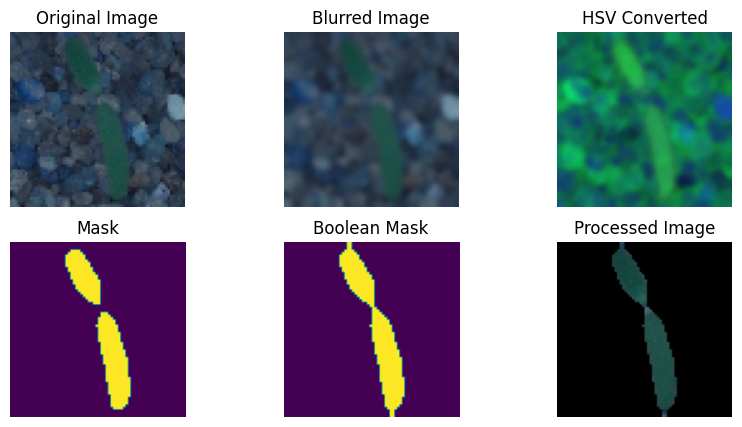

In [ ]:
foreground_extraction(trainingset,plot=True)

In [ ]:
new_train = np.asarray(new_train)

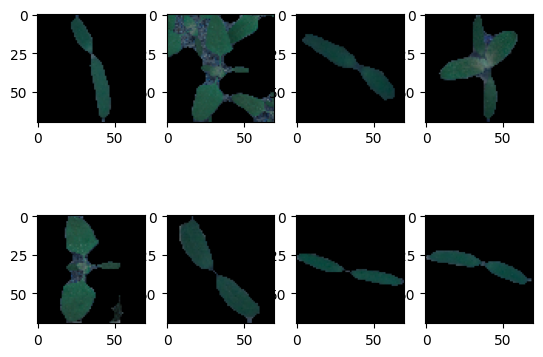

In [ ]:
for i in range(8):new_train = np.asarray(new_train)
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'ShepherdΓÇÖs Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


<Axes: >

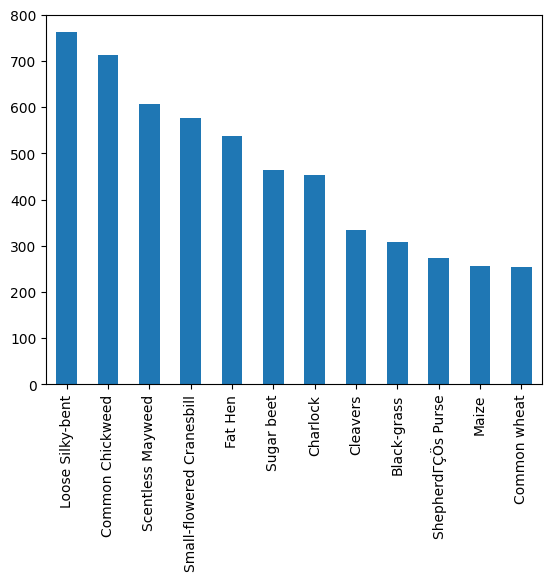

In [ ]:
encoder = LabelEncoder()
encoder.fit(traininglabels[0])
print('Classes'+str(encoder.classes_))
encodedlabels = encoder.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='bar')

In [ ]:
for i in range(0,3200,400):
  print(clearalllabels[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=42,stratify=clearalllabels)

In [ ]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.1,random_state=42,stratify=y_train)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(4486, 70, 70, 3)
(554, 70, 70, 3)
(499, 70, 70, 3)


In [ ]:
sum=x_train.shape[0]+x_test.shape[0]+x_valid.shape[0]

In [ ]:
print(f'{round(x_train.shape[0]*100/sum)}:{round(x_test.shape[0]*100/sum)}:{round(x_valid.shape[0]*100/sum)}')

81:10:9


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import MobileNetV2

In [ ]:
generator=ImageDataGenerator(rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [ ]:
generator.fit(x_train)

(3987, 70, 70, 3)
(1108, 70, 70, 3)
(444, 70, 70, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout
from keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

def cnn(input_shape):
  # Build the CNN
  model = Sequential()
  height,width=input_shape
  model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(height,width,3), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))
  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))
  model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  model.add(BatchNormalization(axis=3))
  model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(BatchNormalization(axis=3))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(12, kernel_regularizer=l2(0.01), activation='softmax'))
  return model

In [ ]:
from keras.utils import plot_model

In [ ]:
# Compile the model
model_cnn=cnn((70,70))
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

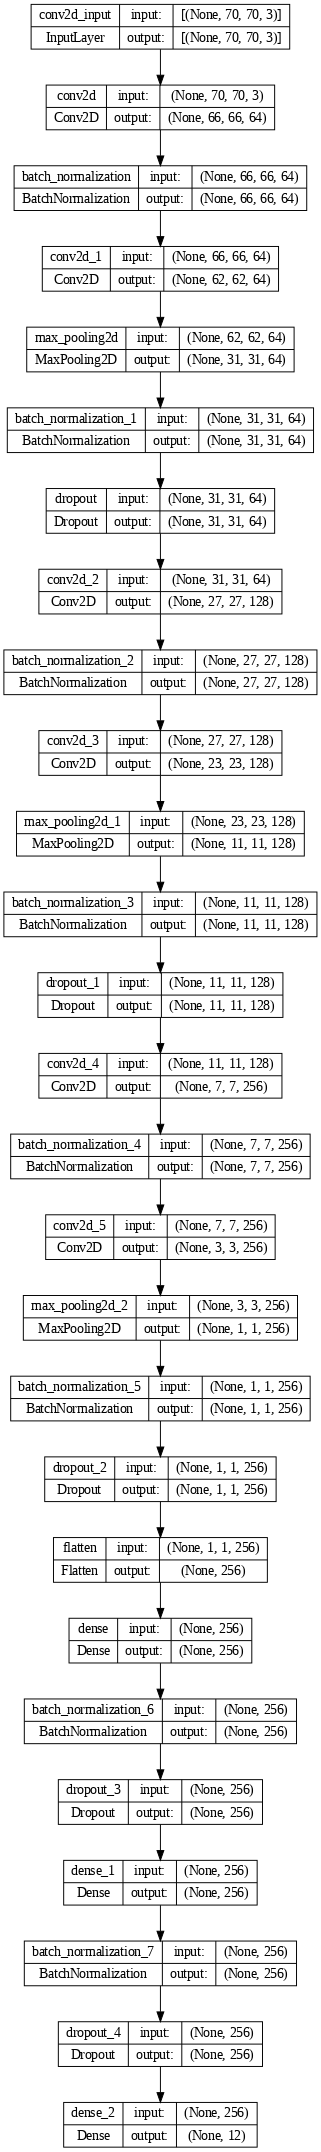

In [ ]:
plot_model(model_cnn, 
           to_file='model.png',           
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 66, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 66, 66, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
batch_size=32
train_steps = len(x_train)//batch_size
valid_steps = len(x_test)//batch_size

if len(x_train) % batch_size != 0:
    train_steps += 1

if len(x_test) % batch_size != 0:
    valid_steps += 1

In [ ]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger, EarlyStopping

In [ ]:
filepath_start="/content/results/model.h5"
filepath_end="/content/results/endmodel.h5"
csv_path='/content/results/data.csv'
callbacks_list = [
    ModelCheckpoint(filepath_start,  verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, min_lr=0.00001),
    EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
    CSVLogger(csv_path),
    ModelCheckpoint(filepath_end, verbose=1, save_best_only=True),
]

In [ ]:
# Train the model
history=model_cnn.fit(x_train, y_train, epochs=50,
                  batch_size=32,validation_data=(x_valid,y_valid),
                  steps_per_epoch=train_steps, callbacks=callbacks_list)

Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 2.5955 - accuracy: 0.2976
Epoch 1: val_loss improved from inf to 9.18729, saving model to /content/results/model.h5

Epoch 1: val_loss improved from inf to 9.18729, saving model to /content/results/endmodel.h5
141/141 [==============================] - 669s 5s/step - loss: 2.5955 - accuracy: 0.2976 - val_loss: 9.1873 - val_accuracy: 0.2505 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 1.7949 - accuracy: 0.4603
Epoch 2: val_loss improved from 9.18729 to 1.92864, saving model to /content/results/model.h5

Epoch 2: val_loss improved from 9.18729 to 1.92864, saving model to /content/results/endmodel.h5
141/141 [==============================] - 647s 5s/step - loss: 1.7949 - accuracy: 0.4603 - val_loss: 1.9286 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 1.4702 - accuracy: 0.5415
Epoch 3: val_loss improved from 1.92864 to 1.2

In [ ]:
# Extract features from the CNN and train the SVM
svm_train_features = model_cnn.predict(x_train)
svm_test_features = model_cnn.predict(x_test)

18/18 [==============================] - 18s 989ms/step


In [ ]:
svm = SVC(kernel='linear', C=1.0)
svm.fit(svm_train_features,  y_train.argmax(axis=1))

# Evaluate the SVM on the test data
svm_acc = svm.score(svm_test_features, y_test.argmax(axis=1))
print("SVM accuracy:", svm_acc)

SVM accuracy: 0.8844765342960289


In [ ]:
import matplotlib.pyplot as plt
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(8,4))

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')

    ax[1].plot(history.history['accuracy'],label='Train Precision')
    ax[1].plot(history.history['val_accuracy'],label='Validation Precision')

    plt.show();
    return plt

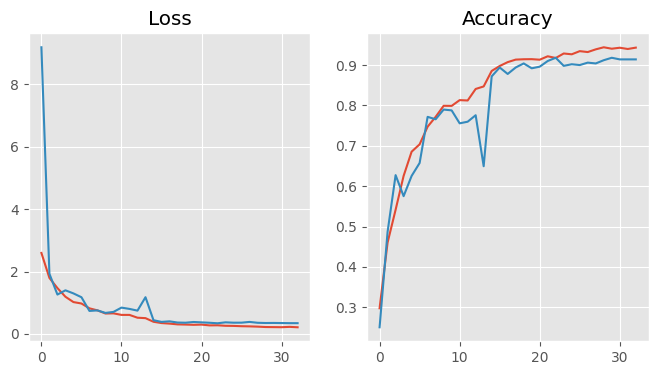

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [ ]:
show_final_history(history)

In [ ]:
# LOADING MODEL
model_cnn.load_weights("/content/results/model.h5")
print(model_cnn.evaluate(x_train, y_train))  # Evaluate on train set
print(model_cnn.evaluate(x_test, y_test))  # Evaluate on test set

141/141 [==============================] - 198s 1s/step - loss: 0.1868 - accuracy: 0.9438
[0.1867578625679016, 0.9438252449035645]
18/18 [==============================] - 25s 1s/step - loss: 0.3448 - accuracy: 0.8845
[0.3448401689529419, 0.8844765424728394]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

18/18 [==============================] - 24s 1s/step


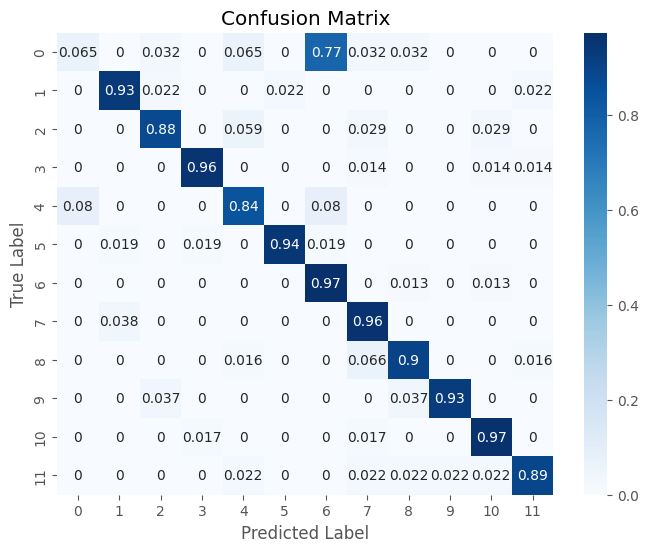

In [ ]:
# PREDICTIONS
y_pred = model_cnn.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 
cmatrix = confusion_matrix(y_check, y_class)
cm_norm = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# fileList=[]
# for root, dirs, files in os.walk('/content/'):
#     # Use glob to get all files with the .nii extension
#     image_file = glob(os.path.join(root, '*.png'))
#     filtered_list = [s for s in image_file if 'nonsegmentedv2' in s]

#     if(filtered_list!=[]):
#        fileList.append(filtered_list)
# imageList=[item for sublist in fileList for item in sublist]

# labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], imageList))
# print(imageList)
# print(labels)

In [ ]:
# # pics = sorted(glob(os.path.join("/content/nonsegmentedv2/", "*.png")))

# # path_to_test = '/content/nonsegmentedv2/*.png'
# # pics = glob(path_to_test)
# testimages = []
# tests = []
# count=1
# num = len(imageList)
# print(num)
# for i in imageList:
#     print(str(count)+'/'+str(num),end='r')
#     tests.append(i.split('/')[-1])
#     testimages.append(cv2.resize(cv2.imread(i),(70,70)))
#     count = count + 1
# testimages = np.asarray(testimages)

In [ ]:
# files = os.listdir("/content/nonsegmentedv2")
# len(files)

In [ ]:
# newtestimages = []
# sets = []
# def foreground_extraction(testset,plot=True):
#   for i in testset:
#       if plot == True:
#         f, plots = plt.subplots(2, 3, figsize=(10,5))
#       if plot ==True:
#         plots[0][0].axis("off")
#         plots[0][0].set_title('Original Image')
#         plots[0][0].imshow(i)
        
#       blurr = cv2.GaussianBlur(i,(5,5),0)
#       if plot ==True:
#         plots[0][1].axis("off")
#         plots[0][1].set_title('Blurred Image')
#         plots[0][1].imshow(blurr)

#       hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
#       if plot ==True:
#         plots[0][2].axis("off")
#         plots[0][2].set_title('HSV Converted')
#         plots[0][2].imshow(hsv)

#       lower = (25,40,50)
#       upper = (75,255,255)      
#       mask = cv2.inRange(hsv,lower,upper)
#       if plot ==True:
#         plots[1][0].axis("off")
#         plots[1][0].set_title('Mask')
#         plots[1][0].imshow(mask)
      
#       struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
#       mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
#       boolean = mask>0
#       if plot ==True:
#         plots[1][1].axis("off")
#         plots[1][1].set_title('Boolean Mask')
#         plots[1][1].imshow(boolean)

#       new = np.zeros_like(i,np.uint8)
#       new[boolean] = i[boolean]
#       if plot ==True:
#         plots[1][2].axis("off")
#         plots[1][2].set_title('Processed Image')
#         plots[1][2].imshow(new)

#       newtestimages.append(new)
#       plot = False

In [ ]:
# foreground_extraction(testimages,True)

In [ ]:
# print(newtestimages[0])
# #NORMALIZATION
# newtestimages_norm = []
# for image in newtestimages:
#     # Normalize the image values
#     image_norm = image / 255.0
#     newtestimages_norm.append(image_norm)
# prediction = model_cnn.predict(np.array(newtestimages))
# # PREDICTION TO A CSV FILE
# pred = np.argmax(prediction,axis=1)
# predStr = labels.classes_[pred]
# result = {'file':tests,'species':predStr}
# result = pd.DataFrame(result)
# result.to_csv("Prediction.csv",index=False)